In [ ]:
                                        #########################################
                                        #########################################

                                                        A/B-test

                                        #########################################
                                        #########################################

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
%matplotlib inline

In [2]:
plt.style.use('ggplot')                       # Красивые графики
plt.rcParams['figure.figsize'] = (16, 9)

In [3]:
#  Загрузим и посмотрим на данные.

df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [ ]:

Посмотрим, что известно и что требуется:

В контрольной группе (а) 1928 платящих из 202103.
В тестовой группе (b) 1805 платящих из 202667.
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной.


Какой набор предложений можно считать лучшим? 
Какие метрики стоит проанализировать для принятия правильного решения и как?


In [ ]:

Проверим, статичтически значимо или нет преимущество ARPU тестовой
группы над ARPU контрольной группы.

Но для начала проверим сплитовалку, стоит ли верить нашему A/B-тесту?
Проведём A/A-тест.


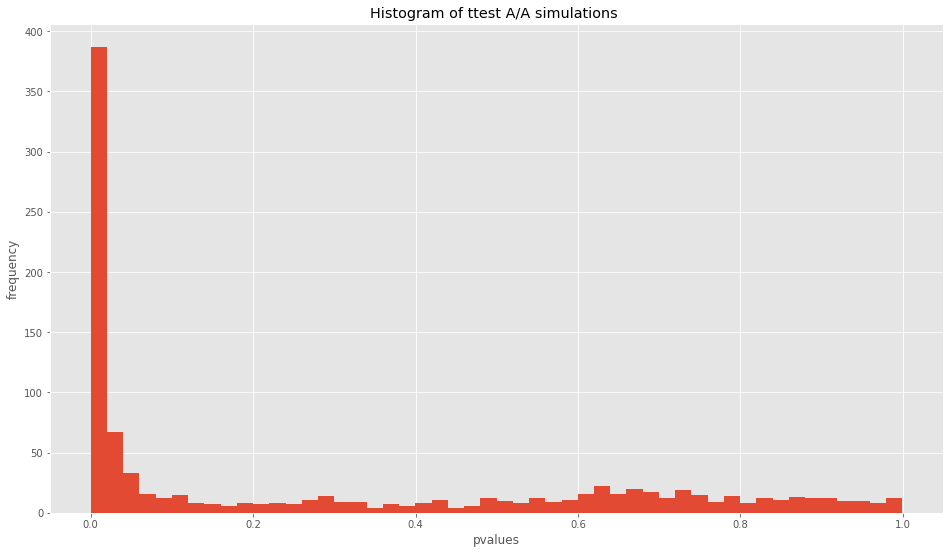

0.472

In [4]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.testgroup == "a"]['revenue'].sample(n_s, replace = False).values
    s2 = df[df.testgroup == "b"]['revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:

Похоже, наша сплит-система работает неверно. Но ведь наши продакты, 
которые проводили A/B-тест, вряд ли ошиблись. А может дело в данных? Посмотрим.


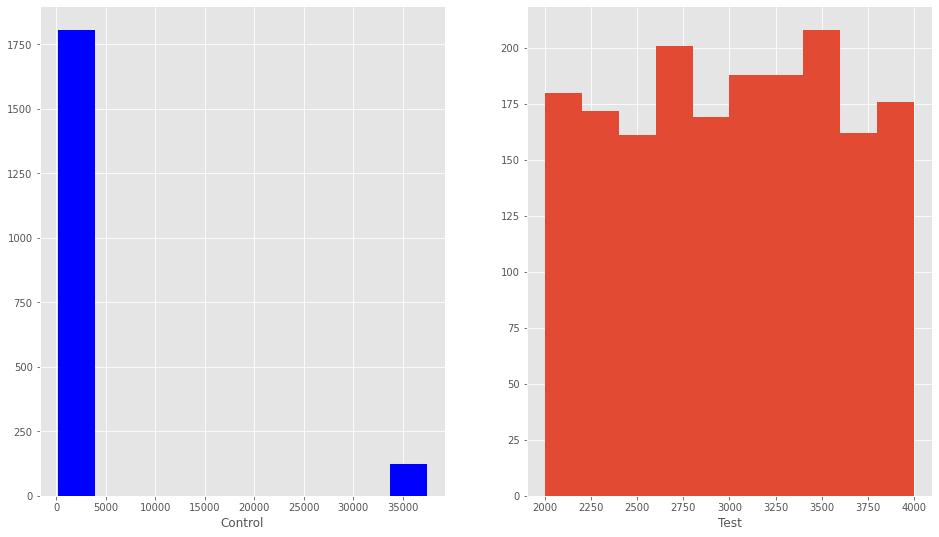

In [5]:

#  Построим распределения платящих пользователей для контрольной и тестовой групп.


plt.subplot(1, 2, 1)
df.query('testgroup == "a" and revenue > 0')['revenue'].hist(color='blue')
plt.xlabel('Control')

plt.subplot(1, 2, 2)
df.query('testgroup == "b" and revenue > 0')['revenue'].hist()
plt.xlabel('Test')

sns.despine()

In [ ]:

Выбросы в контрольной группе. Интересно, откуда они взялись... В любом случае, исключить мы их не можем, потому что не знаем 
природы возникновения. Значит для оценки нужен критерий, устойчивый к выбросам: обратимся к U-критерию Манна-Уитни.
    

In [6]:

#  Проведём тест и посмотрим на p-уровень значимости.


statistic, pvalue = stats.mannwhitneyu(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)
print('pvalue =', pvalue.round(2))

pvalue = 0.03


In [7]:

#  Посчитаем ARPU для контрольной и тестовой групп.


ARPU_control = df.query('testgroup == "a"').revenue.mean().round(2)
ARPU_test = df.query('testgroup == "b"').revenue.mean().round(2)

print('ARPU_control =',ARPU_control)
print('ARPU_test =',ARPU_test)
print(f'ARPU_test > ARPU_control на {round((ARPU_test-ARPU_control)/ARPU_test*100, 2)}%')

ARPU_control = 25.41
ARPU_test = 26.75
ARPU_test > ARPU_control на 5.01%


In [ ]:

Итак, с помощью U-критерия Манна-Уитни удалось определить: ARPU тестовой группы статистически значимо выше, 
чем ARPU контрольной группы на 5.01%.
Но pvalue = 0.03... Это конечно хорошо, если α = 0.05. Но нам очень не хочется совершить ошибку первого рода, приняв 
альтернативную гипотезу, и отклонив при этом верную - нулевую. Поэтому, если мы примем α = 0.01 для большей уверенности,
то поводов для отклонения нулевой гипотезы уже не будет.


In [ ]:

Чтобы подстраховаться, обратимся к "универсальному инструменту", результаты которого потенциально более точны: Bootstrap.  


In [8]:
sample_1 = df.query('testgroup == "a"').revenue
sample_2 = df.query('testgroup == "b"').revenue

df2 = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

df2 = df2.fillna(0)

In [13]:
#  Помним о выбросах, поэтому используем в качестве меры центральной тенденции медиану.

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.99 # зададим уровень в соответствии с нашей новой α = 0.01.
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

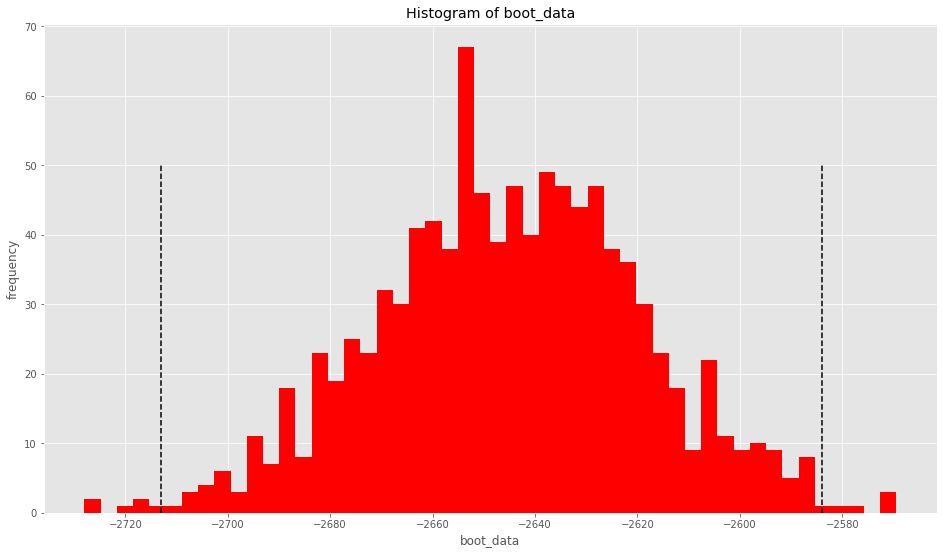

In [14]:
booted_data_median = get_bootstrap(df2.query('sample_1 != 0').sample_1, df2.query('sample_2 != 0').sample_2)

In [15]:
booted_data_median['quants']

,0
0.005,-2713.0175
0.995,-2583.9800


In [16]:
booted_data_median['p_value']

0.0

In [ ]:

Видим, что доверительный интервал вышел за 0, а p_value = 0.0.

Вот так уже лучше, теперь с определённой уверенностью мы можем сказать, что 
в тестовой группе статистически значимо увеличился ARPU по отношению к контрольной группе.

Но мы также не могли не заметить, что в тестовой группе, которая сама по себе немного больше, 
чем контрольная, платящих пользователей стало меньше, чем в контрольной. Нужно проверить, имеет ли
такое снижение платящих пользователей статистическую значимость.


In [17]:
# Воспользуемся А/В тестом для пропорций.

# В контрольной группе (а) 1928 платящих из 202103.

# В тестовой группе (b) 1805 платящих из 202667.


s1 = 1928
n1 = 202103
s2 = 1805
n2 = 202667

In [18]:
# Проведём сам тест:

z, p_value = sm.stats.proportions_ztest([s1, s2], [n1, n2])

print('p_value =', p_value)


p_value = 0.035028524642854865


In [ ]:

И что мы видим: p_value < 0.05. Значит количество платящих пользователей
статистически значимо уменьшилось(по крайней мере если опираться на α = 0.05). 
Это для нас нехорошо.

Но мы помним про выбросы. А что если если был сбой системы, и все наши "VIP-плательщики"
на самом деле не заплатили ничего. Тогда тест покажет другой результат.


In [19]:
s3 = 1805
n3 = 202103
s4 = 1805
n4 = 202667

In [20]:
z2, p_value2 = sm.stats.proportions_ztest([s3, s4], [n3, n4])
print('p_value =', p_value2)

p_value = 0.9329809027702953


In [ ]:

Всё упирается в выбросы.


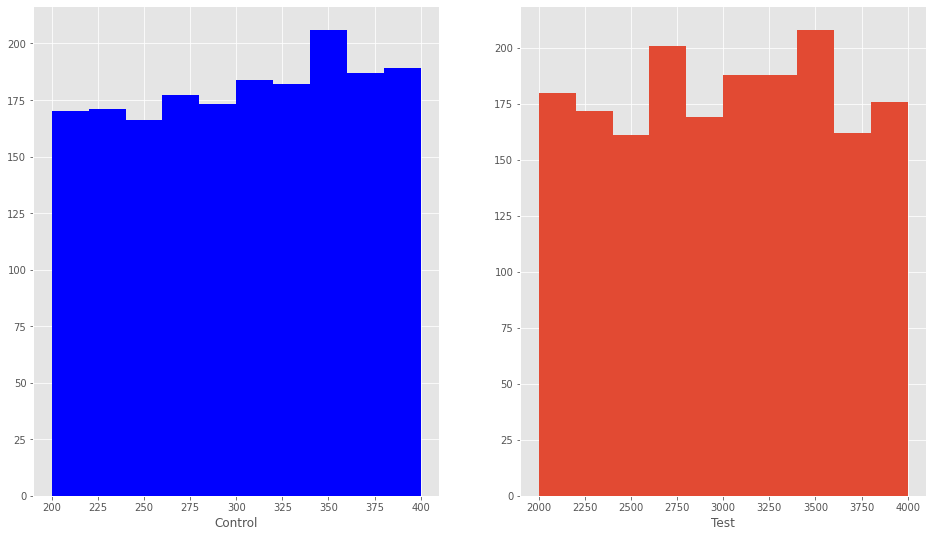

In [21]:

#  Построим распределения платящих пользователей для контрольной и тестовой групп, но теперь без учёта выбросов.


plt.subplot(1, 2, 1)
df.query('testgroup == "a" and 0 < revenue < 5000')['revenue'].hist(color='blue')
plt.xlabel('Control')

plt.subplot(1, 2, 2)
df.query('testgroup == "b" and revenue > 0')['revenue'].hist()
plt.xlabel('Test')

sns.despine()

In [ ]:

По графикам видно, что, если не принимать во внимание выбросы в контрольной группе, то
размах Revenue в контрольной группе 200 - 400, а в тестовой 2000 - 4000. Разница очевидна. Посчитаем точно.


In [30]:

#  ARPPU контрольной группы без выбросов и ARPPU тестовой группы.


ARPPU_control = df.query('testgroup == "a" and 0 < revenue < 30000').revenue.mean().round(2)
ARPPU_test = df.query('testgroup == "b" and revenue > 0').revenue.mean().round(2)

print('ARPPU_control =', ARPPU_control)
print('ARPPU_test =', ARPPU_test)


#  Тут видим десятикратное превосходство ARPPU тестовой группы

ARPPU_control = 302.46
ARPPU_test = 3003.66


In [22]:

#  Посмотрим на характеристики наших "VIP-пользователей"


df.query('testgroup == "a" and revenue > 5000').revenue.describe()

#  Всего 123 пользователя и подозрительно маленькое стандартное отклонение.

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

In [ ]:


Выводы:
    
    1) Проанализировав данные, мы установили, что ARPU в тестовой группе статистически значимо увеличилось
    на 5% по сравнению с контрольной группой.
    
    2) Также мы увидели выбросы в контрольной группе, которые говорят либо о поломке в системе сплитования,
    либо о наличии в ней группы пользователей, которым настолько нравится наше приложение в том виде, в котором оно
    есть, что они всё покупают и покупают самые дорогие саженцы и лейки 99 уровня, каждая из которых может полить за
    один раз до 1Га их любимого сада:)(это, конечно, маловероятно - выбросы слишком уж велики и мало отличаются между собой).
    
    3) Если проблемы с системой сплитования, нужно их решать, затем снова проводить тесты.
    
    4) В остальных случаях, если поломки нет(выбросы - реальные пользователи; баг программы, записавший в "VIP-пользователи" 
    тех, кто на самом деле ничего не заплатил), то мы принимаем изменения с одной лишь разницей: если "VIP-пользователи"
    реальны, то на них изменения пока не раскатываем(по ним лучше отдельно провести свой А/В-тест и посмотреть, 
    нравится им или нет), если же баг, и вместо больших сумм - нули, то просто раскатываем на всех.


